# BASICS 02 - Training the network

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

/home/antoine/homhots/HOTS/HOTS


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import cv2
import time
from tqdm import tqdm_notebook as tqdm
from mix_Network import *

# Loading the events

In [4]:
    datapath = "../Data/alphabet_ExtractedStabilized.mat"
    #Extracted from past code (vic_Event.py) 
    import scipy
    def LoadFromMat(path, image_number, OutOnePolarity=False, verbose=0):
        '''
        Load Events from a .mat file. Only the events contained in ListPolarities are kept:
        INPUT
            + path : a string which is the path of the .mat file (ex : './data_cache/alphabet_ExtractedStabilized.mat')
            + image_number : list with all the numbers of image to load
        '''
        obj = scipy.io.loadmat(path)
        ROI = obj['ROI'][0]

        if type(image_number) is int:
            image_number = [image_number]
        elif type(image_number) is not list:
            raise TypeError(
                'the type of argument image_number should be int or list')
        if verbose > 0:
            print("loading images {0}".format(image_number))
        Total_size = 0
        for idx, each_image in enumerate(image_number):
            image = ROI[each_image][0, 0]
            Total_size += image[1].shape[1]

        address = np.zeros((Total_size, 2)).astype(int)
        time = np.zeros((Total_size))
        polarity = np.zeros((Total_size))
        first_idx = 0

        for idx, each_image in enumerate(image_number):
            image = ROI[each_image][0, 0]
            last_idx = first_idx + image[0].shape[1]
            address[first_idx:last_idx, 0] = (image[1] - 1).astype(int)
            address[first_idx:last_idx, 1] = (image[0] - 1).astype(int)
            time[first_idx:last_idx] = (image[3] * 1e-6)
            polarity[first_idx:last_idx] = image[2].astype(int)
            first_idx = last_idx

        polarity[polarity.T == -1] = 0
        polarity = polarity.astype(int)
        # Filter only the wanted polarity
        ListPolarities = np.unique(polarity)
        if OutOnePolarity == True:
            polarity = np.zeros_like(polarity)
            ListPolarities = [0]
            
        return address, time, polarity, ListPolarities

In [6]:
image_list = [1, 32, 19, 22, 29]
image_list += image_list
image_list += image_list
address, time, polarity, list_pola = LoadFromMat(datapath, image_number=image_list)

# Training

- krnlinit='first' means that the first 4 time-surfaces are used of initialisation of the layers
- with the .run method each event pass by all layers during training (learning of the different layers takes place simultaneously) 

In [7]:
hots = network(algo='lagorce', krnlinit='first')
count = 0
nbevent = int(time.shape[0])
pbar = tqdm(total=nbevent)
while count<nbevent:
    if time[count]<time[count-1]:
        for i in range(len(hots.TS)):
            hots.TS[i].spatpmat[:] = 0
            hots.TS[i].iev = 0
    pbar.update(1)
    hots.run(address[count,1],address[count,0],time[count],polarity[count],learn=True, to_record=True)
    count += 1
pbar.close()
for l in range(len(hots.L)):
    hots.stats[l].histo = hots.L[l].cumhisto.copy()

<ipython-input-7-3e60b286bff8>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=nbevent)


  0%|          | 0/297828 [00:00<?, ?it/s]

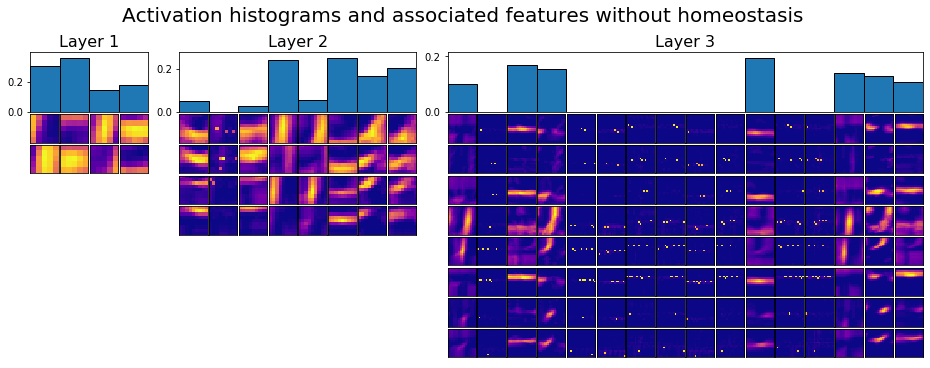

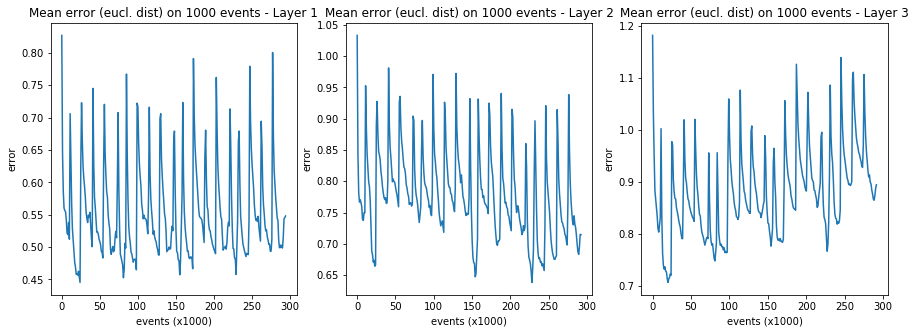

In [12]:
hots.plotlayer()
hots.plotconv()

# Training method including events loading

- this method of learning is inspired from KmeansLagorce and the first layer learns with all the events, then the second layer etc... 
- time-surfaces are filtered for minimum activation (2xR) only in the first layer

In [13]:
hots = network(algo='lagorce', krnlinit='first')
hots.learninglagorce(diginit=True)

  0%|          | 0/223371 [00:00<?, ?it/s]

  0%|          | 0/223371 [00:00<?, ?it/s]

  0%|          | 0/223371 [00:00<?, ?it/s]

# Monitoring

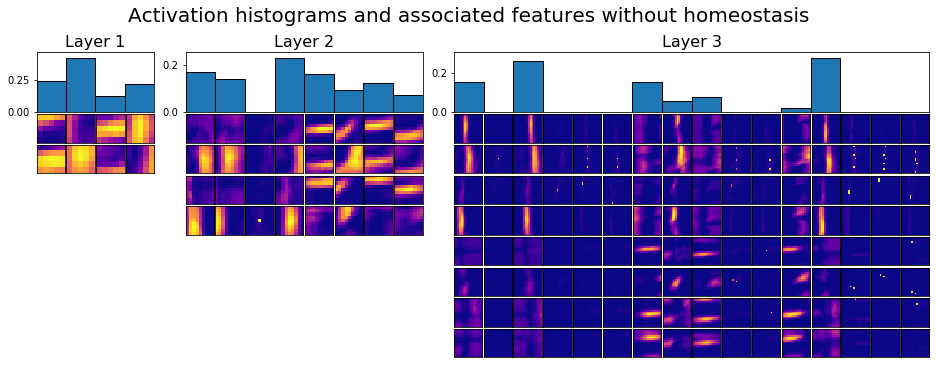

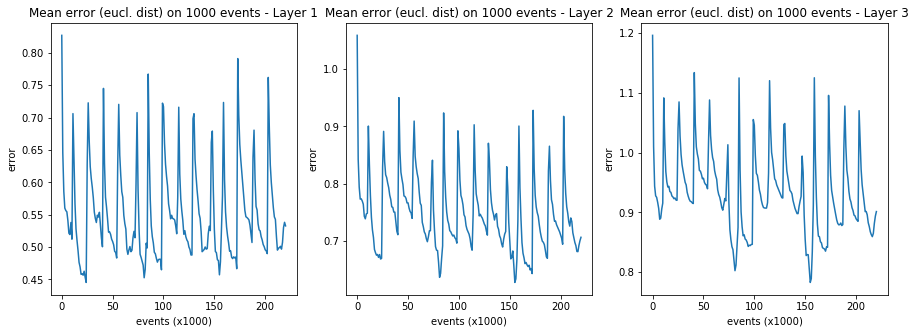

In [14]:
hots.plotlayer()
hots.plotconv()

# Running the trained network on a single image
(you may have to uncommend one line in the .run method of mix_Network)

In [15]:
## Loading and filter an image of a 8
address, time, polarity, list_pola = LoadFromMat(datapath, image_number=[15])

In [16]:
for i in range(len(hots.L)):
    hots.TS[i].spatpmat[:] = 0
    hots.TS[i].iev = 0

count = 0
nbevent = int(time.shape[0])
pbar = tqdm(total=nbevent)
while count<nbevent:
    pbar.update(1)     
    hots.run(address[count,1],address[count,0],time[count], polarity[count], to_record=True)
    count += 1
pbar.close()

<ipython-input-16-d9bdaa892e95>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=nbevent)


  0%|          | 0/14716 [00:00<?, ?it/s]

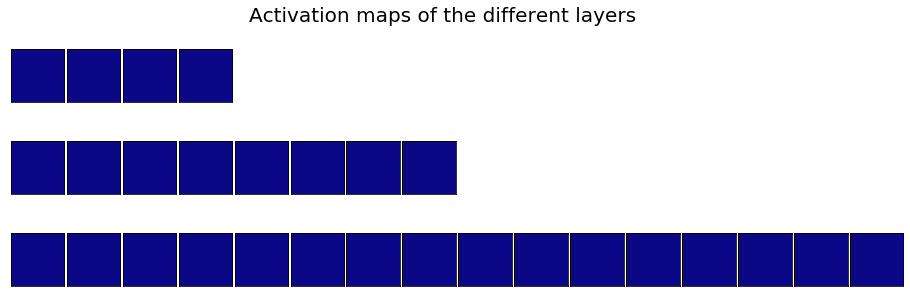

In [9]:
#you may have to uncomment line 286 (around this number to activat update of self.stats[lay].actmap)
#in mix_Network.py
hots.plotactiv()

## Trying harder filtering

In [11]:
for i in range(len(hots.TS)):
    hots.TS[i].spatpmat[:] = 0
    hots.TS[i].iev = 0
    hots.TS[i].filt = 3 #from 2 to 5
    hots.stats[i].actmap[:]=0

count = 0
nbevent = int(time.shape[0])
pbar = tqdm(total=nbevent)
while count<nbevent-1:
    pbar.update(1)
    count += 1
            
    hots.run(address[count,1],address[count,0],time[count], polarity[count], to_record=True)
            
pbar.close()

<ipython-input-11-1cd48ead72c0>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=nbevent)


  0%|          | 0/297828 [00:00<?, ?it/s]

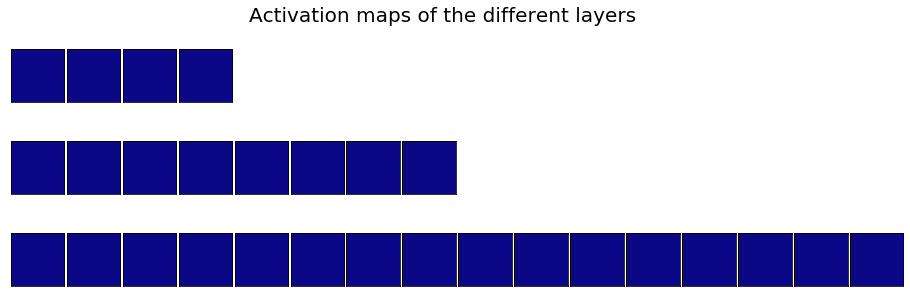

In [12]:
hots.plotactiv()